In [1]:
import os
import sys

# choose the GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# disable preallocation of memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# pcx
import pcx as px
import pcx.predictive_coding as pxc
import pcx.nn as pxnn
import pcx.functional as pxf
import pcx.utils as pxu

# 3rd party
import jax
from jax import jit
import jax.numpy as jnp
import jax.random as random
import optax
import numpy as np
import pandas as pd
from pandas.api.types import is_float_dtype
from ucimlrepo import fetch_ucirepo 

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import timeit

# own
import causal_helpers
from causal_helpers import simulate_dag, simulate_parameter, simulate_linear_sem, simulate_linear_sem_cyclic
from causal_helpers import load_adjacency_matrix, set_random_seed, plot_adjacency_matrices
from causal_helpers import load_graph, load_adjacency_matrix
from causal_metrics import f1_directed, f1_skeleton, compute_auprc, compute_auroc, cycle_f1
from connectome_cyclic_data_generator import sample_cyclic_data

sys.path.append('/home/amine.mcharrak/clear2025/')  # Add parent directory of `dglearn`
from dglearn.dg.adjacency_structure import AdjacencyStucture  # Ensure class name matches exactly
from dglearn.dg.graph_equivalence_search import GraphEquivalenceSearch
from dglearn.evaluation.evaluation_shd import min_colperm_shd as shd_cyclic
from dglearn.dg.converter import binary2array

# Set random seed
seed = 44 # main seed for reproducibility
set_random_seed(seed)

# causal libraries
import cdt, castle

# causal metrics
from cdt.metrics import precision_recall, SHD, SID
from castle.metrics import MetricsDAG
from castle.common import GraphDAG
from causallearn.graph.SHD import SHD as SHD_causallearn

/share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detecting CUDA device(s) : [0]


In [2]:
#   # fetch dataset 
# abalone = fetch_ucirepo(id=1) 
  
# # data (as pandas dataframes) 
# X = abalone.data.features
# y = abalone.data.targets
  
# # metadata 
# #print(abalone.metadata) 

# # now merge X and y to create a single dataframe and give the columns the correct names using abalone.variables.name.values
# df = pd.concat([X, y], axis=1)
# df.columns = abalone.variables.name.values.tolist()
# print(df.head())
# print()
# # show # of unique values in each column
# print(df.nunique())
# # finally convert the Rings variable to a binary variable by setting the threshold to mean(rings)
# df['Rings'] = df['Rings'] > df['Rings'].mean()
# # then convert to integer
# df['Rings'] = df['Rings'].astype(int)
# # also replace the values in Sex with integers
# df['Sex'] = df['Sex'].map({'M': 0, 'F': 1, 'I': 2})

# # now show the first 5 rows of the dataframe
# print(df.head())

# # Create a boolean list for continuous variables (any float dtype)
# is_cont_node = df.dtypes.map(is_float_dtype).tolist()

# # Print the result
# print(is_cont_node)

# # plot the distribution of all variables in the dataframe
# df.hist(figsize=(15, 10))
# plt.show()

# path to mixed_confounding data
#path = '../data/custom_mixed_confounding/'
path = '../data/linear_cyclic/'

# load adjacency matrix and data as pandas dataframe, both files have no header
adj_matrix = pd.read_csv(path + 'adj_matrix.csv', header=None)
data = pd.read_csv(path + 'train.csv', header=None)
weighted_adj_matrix = pd.read_csv(path + 'W_adj_matrix.csv', header=None)
n_vars = data.shape[1]

B_true = adj_matrix.values
X = data.values
W_true = weighted_adj_matrix.values

# get edge list from B_true using networkx
G_true = nx.DiGraph(B_true)
edges_list= list(G_true.edges())
# compute performance metric: SHD
true_graph = AdjacencyStucture(n_vars=n_vars, edge_list=edges_list)
search = GraphEquivalenceSearch(true_graph)
search.search_dfs()
B_true_EC = [binary2array(bstr) for bstr in search.visited_graphs]

In [3]:
data.head()
# show unique values in each column
print(data.nunique())
# Determine if each variable is continuous or discrete based on the number of unique values
is_cont_node = data.nunique() > (len(data) / 2) # if unique values are more than half of the number of samples, then continuous
is_cont_node = is_cont_node.tolist()
print(is_cont_node)

0     4000
1     4000
2     4000
3     4000
4     4000
5     4000
6     4000
7     4000
8     4000
9     4000
10    4000
11    4000
12    4000
13    4000
14    4000
dtype: int64
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [4]:
# # ## Load the actual connectome data

# # %%
# # load the weighted adjacency matrices for ER and connectome

# # Specify the folder where the adjacency matrices were saved
# folder = '../data/'

# # Specify the folder where the acyclic positive integer weighted connectome data was saved
# folder_cyclic = '/home/amine.mcharrak/connectome/data/'
# # Specify the folder where the acyclic positive integer weighted connectome data was saved
# folder_acyclic = '/home/amine.mcharrak/connectome/data/'

# # Example usage to load the saved adjacency matrices
# # G_A_init_t_ordered_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix.npy'))
# # G_A_init_t_ordered_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix.npy'))
# # ER = load_adjacency_matrix(os.path.join(folder, 'ER_adj_matrix.npy'))
# # ER_dag = load_adjacency_matrix(os.path.join(folder, 'ER_dag_adj_matrix.npy'))

# # Change name of the connectome adjacency matrix to C and C_dag
# # C = G_A_init_t_ordered_adj_matrix
# # C_dag = G_A_init_t_ordered_dag_adj_matrix

# # Now ensure that both DAG adjacency matrices are binary, if they aren't already
# # ER_dag_bin = (ER_dag != 0).astype(int)
# # C_dag_bin = (C_dag != 0).astype(int)

# # ER_true = ER_dag_bin
# # C_true = C_dag_bin

# # %% [markdown]
# # ## Create data to debug and implement the pcax version of NOTEARS

# # %%
# # actual data
# B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
# # B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4
# # debugging data
# # B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2


# # B_true = C_dag_bin # if you want to use the connectome-based DAG # best
# #B_true = ER_dag_bin # if you want to use the ER-based DAG

# #B_true = simulate_dag(d=5, s0=10, graph_type='ER') # ER2
# #B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
# #B_true = simulate_dag(d=50, s0=100, graph_type='ER') # ER2
# #B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
# #B_true = simulate_dag(d=279, s0=558, graph_type='ER') # ER2

# # create SF2 graph and SF4 graph with d=10 nodes
# #B_true = simulate_dag(d=10, s0=20, graph_type='SF') # SF2
# #B_true = simulate_dag(d=10, s0=40, graph_type='SF') # SF4
# #B_true = simulate_dag(d=100, s0=400, graph_type='SF') # SF4

# # create ER2 and ER4 graphs with d=100 nodes
# #B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
# #B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4

# # create equivalent ER4 and ER6 graphs
# #B_true = simulate_dag(d=279, s0=1116, graph_type='ER') # ER4
# #B_true = simulate_dag(d=279, s0=1674, graph_type='ER') # ER6

# # create equivalent SF4 and SF6 graphs
# #B_true = simulate_dag(d=100, s0=600, graph_type='SF') # SF6
# #B_true = simulate_dag(d=279, s0=1116, graph_type='SF') # SF4
# #B_true = simulate_dag(d=279, s0=1674, graph_type='SF') # SF6

# # create simple data using simulate_dag method from causal_helpers with expected number of edges (s0) and number of nodes (d)
# #B_true = simulate_dag(d=100, s0=199, graph_type='ER') # we use p≈0.040226 for the connectome-based ER_dag graph. This means that the expected number of edges is 0.040226 * d * (d-1) / 2
# # examples: d=50 -> s0=49 (works), d=100 -> s0=199, d=200 -> s0=800

# # create the weighted adjacency matrix based on the binary adjacency matrix
# #W_true = simulate_parameter(B_true, connectome=True)
# #W_true = simulate_parameter(B_true)

# # sample data from the linear SEM
# # actual data
# #X = simulate_linear_sem(W_true, n=10000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=10000, sem_type='uniform')
# # for debugging
# #X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=2500, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=6250, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=50000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=100000, sem_type='gauss') # 1000*(279**2)/(20**2) = 194602

# # load the cyclic integer weighted connectome data adjacency matrix
# #B_true_weighted = load_adjacency_matrix(os.path.join(folder_cyclic, 'A_init_t_ordered_adj_matrix_with_cycles.npy'))
# #X, W_true = sample_cyclic_data(B_true_weighted, n_samples=10000, noise_type='non-gaussian')
# #B_true = (W_true != 0).astype(int)

# # load the acyclic integer weighted connectome data adjacency matrix
# # B_true_weighted = load_adjacency_matrix(os.path.join(folder_acyclic, 'A_init_t_ordered_adj_matrix_no_cycles.npy'))
# # print("B_true_weighted:\n", np.array_str(B_true_weighted, precision=4, suppress_small=True))

# # A: use this for regular DAGs
# W_true = simulate_parameter(B_true)

# # B: use this for connectome-based DAGs
# #W_true = simulate_parameter(B_true_weighted, connectome=True)
# #B_true = (W_true != 0).astype(int)

# # some print statements to check the values of W_true
# print("W_true:\n", np.array_str(W_true, precision=4, suppress_small=True))
# print("Mean of W_true:", np.mean(W_true))
# print("Variance of W_true:", np.var(W_true))
# print("Max value in W_true:", np.max(W_true))
# print("Min value in W_true:", np.min(W_true))

# # sample data from the linear SEM
# X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')

# # now standardized data, where each variable is normalized to unit variance
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_std = scaler.fit_transform(X)

# # NOTE: you may not write positional arguments after keyword arguments. 
# # That is, the values that you are passing positionally have to come first!

# # create a dataset using the simulated data
# # NOTE: NOTEARS paper uses n=1000 for graph with d=20.
# # NOTE: d... number of nodes, p=d^2... number of parameters, n... number of samples. Then: comparing p1=d1^2 vs p2=d2^2 we have that: n1/p1 must be equal to n2/p2
# # Thus we have n2 = n1 * p2 / p1. For the case of d2=100 we have that n2 = (n1*p2)/p1 = 1000*(100^2)/(20^2) = 25000 
# # we should expect to use that many samples actually to be able to learn the graph in a comparable way.
# #dataset = IIDSimulation(W=W_true, n=25000, method='linear', sem_type='gauss')
# #true_dag, X = dataset.B, dataset.X

In [5]:
# print how many non-zero entries are in the true DAG
print(f"Number of non-zero entries in the true DAG: {np.count_nonzero(B_true)}")

Number of non-zero entries in the true DAG: 96


In [6]:
class Complete_Graph(pxc.EnergyModule):
    def __init__(self, input_dim: int, n_nodes: int, has_bias: bool = False, is_cont_node: list = None) -> None:
        super().__init__()

        self.input_dim = px.static(input_dim)  # Ensure input_dim is static
        self.n_nodes = px.static(n_nodes)  # Keep n_nodes as a static value
        self.has_bias = has_bias
        self.is_cont_node = is_cont_node

        # Initialize a single linear layer for the weights and wrap it in a list
        self.layers = [pxnn.Linear(n_nodes, n_nodes, bias=has_bias)] # vanilla initialization is uniform(-stdv, stdv) with stdv = 1/sqrt(n_nodes), here n_nodes = 12, thus stdv = 1/sqrt(12) = 0.2887
        
        #stddev = jnp.sqrt(0.01) # this equals 0.1 (default would have been 0.2887)
        stddev = 1/n_nodes
        key = random.PRNGKey(0)
        #new_weight_matrix = random.normal(key, shape=(n_nodes, n_nodes)) * stddev # option 1 using normal distribution
        new_weight_matrix = random.uniform(key, shape=(n_nodes, n_nodes), minval=-stddev, maxval=stddev) # option 2 using uniform distribution

        # Step 3: Replace diagonal elements with 0
        for i in range(n_nodes):
            new_weight_matrix = new_weight_matrix.at[i, i].set(0.0)

        # Step 5: Update the weight matrix
        self.layers[0].nn.weight.set(new_weight_matrix)

        # Initialize vodes based on is_cont_node
        if is_cont_node is None:
            is_cont_node = [True] * n_nodes  # Default to all continuous nodes if not provided

        self.vodes = []
        for is_cont in is_cont_node:
            if is_cont:
                self.vodes.append(pxc.Vode())
            else:
                #self.vodes.append(pxc.Vode(pxc.ce_energy))
                self.vodes.append(pxc.Vode(pxc.bce_energy))

    def freeze_nodes(self, freeze=True):
        """Freeze or unfreeze all vodes in the model."""
        for vode in self.vodes:
            vode.h.frozen = freeze

    def are_vodes_frozen(self):
        """Check if all vodes in the model are frozen."""
        return all(hasattr(vode.h, 'frozen') and vode.h.frozen for vode in self.vodes)
    
    def get_W(self):
        """This function returns the weighted adjacency matrix based on the linear layer in the model."""
        W = self.layers[0].nn.weight.get()
        W_T = W.T
        return W_T

    def __call__(self, x=None):
        n_nodes = self.n_nodes.get()

        if x is not None:
            # Initialize nodes with given data
            reshaped_x = x.reshape(n_nodes, -1)  # Infer input_dim from x
            
            # Print the shape of reshaped_x[0] when x is not None
            print("The shape of reshaped_x[0] when x is not None is: ", reshaped_x[0].shape)

            for i in range(n_nodes):
                self.vodes[i](reshaped_x[i])

        else:
            # Stack current state of vodes into a matrix of shape (n_nodes, input_dim)
            x_ = jnp.vstack([vode.get('h') for vode in self.vodes])

            # Print the shape of x_ when x is None
            print("The shape of x_ when x is None is: ", x_.shape)

            # Apply the linear transformation
            output = self.layers[0](x_)

            # Print the shape of output when x is None
            print("The shape of output when x is None is: ", output.shape)

            # Update the vodes with the output
            for i in range(n_nodes):
                self.vodes[i](output[i])

        # Stack the final state of vodes for output
        output = jnp.vstack([vode.get('h') for vode in self.vodes])

        # Print the shape of the output
        print("The shape of the output is: ", output.shape)

        return output

# Usage
input_dim = 1
n_nodes = X.shape[1]
#model = Complete_Graph(input_dim, n_nodes, has_bias=False)
#model = Complete_Graph(input_dim, n_nodes, has_bias=True)
model = Complete_Graph(input_dim, n_nodes, has_bias=True, is_cont_node=is_cont_node)
# Get weighted adjacency matrix
W = model.get_W()
print("This is the weighted adjacency matrix:\n", W)
print()
print("The shape of the weighted adjacency matrix is: ", W.shape)
print()
#print(model)
print()

# Check if all nodes are frozen initially
print("Initially, are all nodes frozen?:", model.are_vodes_frozen())
print()

# Freezing all nodes
print("Freezing all nodes...")
model.freeze_nodes(freeze=True)
print()

# Check if all nodes are frozen after freezing
print("After freezing, are all nodes frozen?:", model.are_vodes_frozen())
print()

# Unfreezing all nodes
print("Unfreezing all nodes...")
model.freeze_nodes(freeze=False)
print()

# Check if all nodes are frozen after unfreezing
print("After unfreezing, are all nodes frozen?:", model.are_vodes_frozen())

This is the weighted adjacency matrix:
 [[ 0.00000000e+00  4.03265655e-03 -5.28676361e-02 -2.89857723e-02
  -6.31347299e-04  3.49136665e-02  6.26156405e-02 -1.15478188e-02
   3.24428082e-02  5.94943836e-02 -1.80560127e-02 -7.84708560e-03
   5.55773005e-02  5.51020950e-02  3.11376080e-02]
 [ 2.08646655e-02  0.00000000e+00  5.09902686e-02  3.33644897e-02
   2.91960537e-02 -5.25922626e-02  6.59828261e-02 -5.63310087e-03
  -5.96398562e-02  3.14296409e-02 -2.81077065e-02 -2.25535780e-03
  -7.44074583e-04 -4.21709083e-02  4.84000891e-03]
 [-9.38210636e-03  5.74440062e-02  0.00000000e+00  1.82621479e-02
   1.58750713e-02  3.81274074e-02 -1.10025108e-02 -1.88252777e-02
   5.22875637e-02 -5.10334522e-02 -5.56579158e-02  5.87510243e-02
   3.67924199e-02 -6.12800010e-02 -5.86270057e-02]
 [-4.88945171e-02  4.19971347e-03  6.13280162e-02  0.00000000e+00
  -1.80494040e-03  1.58987194e-02  3.42585593e-02  2.38987133e-02
  -3.12031284e-02 -3.72390933e-02 -3.35307419e-03  4.61241603e-03
  -1.67021751e-

In [7]:
model.is_cont_node

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [8]:
# TODO: make the below params global or input to the functions in which it is used.
#w_learning_rate = 1e-3
w_learning_rate = 5e-3
h_learning_rate = 1e-4
T = 1

nm_epochs = 6000 # not much happens after 2000 epochs
every_n_epochs = 100
batch_size = 256

# F1 score of ca. 65% with below hyperparameters (which is the best so far)
lam_h = 1
lam_l1 = 4e-2

# Create a file name string for the hyperparameters
exp_name = f"bs_{batch_size}_lrw_{w_learning_rate}_lrh_{h_learning_rate}_lamh_{lam_h}_laml1_{lam_l1}_epochs_{nm_epochs}"
print("Name of the experiment: ", exp_name)

# Training an1d evaluation functions
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), in_axes=(0,), out_axes=0)
def forward(x, *, model: Complete_Graph):
    return model(x)

# @pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, 0), axis_name="batch") # if only one output
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, None, None, None, 0), axis_name="batch") # if multiple outputs
def energy(*, model: Complete_Graph):

    print("Energy: Starting computation")
    x_ = model(None)
    print("Energy: Got model output")
    
    W = model.get_W()
    d = model.n_nodes.get()
    print(f"Energy: Got W (shape: {W.shape}) and d: {d}")

    # PC energy term
    pc_energy = jax.lax.pmean(model.energy(), axis_name="batch")
    print(f"Energy: PC energy term: {pc_energy}")

    # L1 regularization using adjacency matrix (scaled by Frobenius norm)
    l1_reg = jnp.sum(jnp.abs(W)) / (jnp.linalg.norm(W, ord='fro') + 1e-8)
    #l1_reg = jnp.sum(jnp.abs(W)) / d
    print(f"Energy: L1 reg term: {l1_reg}")

    # DAG constraint (stable logarithmic form)
    h_reg = (jnp.trace(jax.scipy.linalg.expm(jnp.multiply(W, W))) - d) / (jnp.sqrt(d) + 1e-8)
    #h_reg = (jnp.trace(jax.scipy.linalg.expm(jnp.multiply(W, W))) - d) / d  # with normalization
    print(f"Energy: DAG constraint term: {h_reg}")
        
    # Combined loss
    obj = pc_energy + lam_h * h_reg + lam_l1 * l1_reg
    print(f"Energy: Final objective: {obj}")

    # Ensure obj is a scalar, not a (1,) array because JAX's grad and value_and_grad functions are designed
    # to compute gradients of *scalar-output functions*
    obj = obj.squeeze()  # explicitly converte the (1,) array (obj) to a scalar of shape ()  
    
    return obj, pc_energy, h_reg, l1_reg, x_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    print("1. Starting train_on_batch")  

    model.train()
    print("2. Model set to train mode")

    model.freeze_nodes(freeze=True)
    print("3. Nodes frozen")

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        print("4. Doing forward for initialization")
        forward(x, model=model)
        print("5. After forward for initialization")

    """
    # The following code might not be needed as we are keeping the vodes frozen at all times
    # Reinitialize the optimizer state between different batches
    optim_h.init(pxu.M(pxc.VodeParam)(model))

    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, x_), g = pxf.value_and_grad(
                pxu.M(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(model=model)
        optim_h.step(model, g["model"], True)
    """

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("6. Before computing gradients")
        (obj, (pc_energy, h_reg, l1_reg, x_)), g = pxf.value_and_grad(
            pxu.M(pxnn.LayerParam).to([False, True]), 
            has_aux=True
        )(energy)(model=model) # pxf.value_and_grad returns a tuple structured as ((value, aux), grad), not as six separate outputs.
        
        print("7. After computing gradients")
        #print("Gradient structure:", g)

        print("8. Before zeroing out the diagonal gradients")
        # Zero out the diagonal gradients using jax.numpy.fill_diagonal
        weight_grads = g["model"].layers[0].nn.weight.get()
        weight_grads = jax.numpy.fill_diagonal(weight_grads, 0.0, inplace=False)
        # print the grad values using the syntax jax.debug.print("🤯 {x} 🤯", x=x)
        #jax.debug.print("{weight_grads}", weight_grads=weight_grads)
        g["model"].layers[0].nn.weight.set(weight_grads)
        print("9. After zeroing out the diagonal gradients")

        
    print("10. Before optimizer step")
    optim_w.step(model, g["model"])
    #optim_w.step(model, g["model"], scale_by=1.0/x.shape[0])
    print("11. After optimizer step")

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("12. Before final forward")
        forward(None, model=model)
        e_avg_per_sample = model.energy()
        print("13. After final forward")

    model.freeze_nodes(freeze=False)
    print("14. Nodes unfrozen")

    return pc_energy, l1_reg, h_reg, obj

def train(dl, T, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    batch_pc_energies = []
    batch_l1_regs = []
    batch_h_regs = []
    batch_objs = []
    
    for batch in dl:
        pc_energy, l1_reg, h_reg, obj = train_on_batch(
            T, batch, model=model, optim_w=optim_w, optim_h=optim_h
        )
        batch_pc_energies.append(pc_energy)
        batch_l1_regs.append(l1_reg)
        batch_h_regs.append(h_reg)
        batch_objs.append(obj)

    W = model.get_W()

    # Compute epoch averages
    epoch_pc_energy = jnp.mean(jnp.array(batch_pc_energies))
    epoch_l1_reg = jnp.mean(jnp.array(batch_l1_regs))
    epoch_h_reg = jnp.mean(jnp.array(batch_h_regs))
    epoch_obj = jnp.mean(jnp.array(batch_objs))
    
    return W, epoch_pc_energy, epoch_l1_reg, epoch_h_reg, epoch_obj

# %%
@jit
def MAE(W_true, W):
    """This function returns the Mean Absolute Error for the difference between the true weighted adjacency matrix W_true and th estimated one, W."""
    MAE_ = jnp.mean(jnp.abs(W - W_true))
    return MAE_

def compute_binary_adjacency(W, threshold=0.3):
    """
    Compute the binary adjacency matrix by thresholding the input matrix.

    Args:
    - W (array-like): The weighted adjacency matrix (can be a JAX array or a NumPy array).
    - threshold (float): The threshold value to determine the binary matrix. Default is 0.3.

    Returns:
    - B_est (np.ndarray): The binary adjacency matrix where each element is True if the corresponding 
                          element in W is greater than the threshold, otherwise False.
    """
    # Convert JAX array to NumPy array if necessary
    if isinstance(W, jnp.ndarray):
        W = np.array(W)

    # Compute the binary adjacency matrix
    B_est = np.array(np.abs(W) > threshold)
    
    return B_est


def ensure_DAG(W):
    """
    Ensure that the weighted adjacency matrix corresponds to a DAG.

    Inputs:
        W: numpy.ndarray - a weighted adjacency matrix representing a directed graph

    Outputs:
        W: numpy.ndarray - a weighted adjacency matrix without cycles (DAG)
    """
    # Convert the adjacency matrix to a directed graph
    g = nx.DiGraph(W)

    # Make a copy of the graph to modify
    gg = g.copy()

    # Remove cycles by removing edges
    while not nx.is_directed_acyclic_graph(gg):
        h = gg.copy()

        # Remove all the sources and sinks
        while True:
            finished = True

            for node, in_degree in nx.in_degree_centrality(h).items():
                if in_degree == 0:
                    h.remove_node(node)
                    finished = False

            for node, out_degree in nx.out_degree_centrality(h).items():
                if out_degree == 0:
                    h.remove_node(node)
                    finished = False

            if finished:
                break

        # Find a cycle with a random walk starting at a random node
        node = list(h.nodes)[0]
        cycle = [node]
        while True:
            edges = list(h.out_edges(node))
            _, node = edges[np.random.choice(len(edges))]

            if node in cycle:
                break

            cycle.append(node)

        # Extract the cycle path and adjust it to start at the first occurrence of the repeated node
        cycle = np.array(cycle)
        i = np.argwhere(cycle == node)[0][0]
        cycle = cycle[i:]
        cycle = cycle.tolist() + [node]

        # Find edges in that cycle
        edges = list(zip(cycle[:-1], cycle[1:]))

        # Randomly pick an edge to remove
        edge = edges[np.random.choice(len(edges))]
        gg.remove_edge(*edge)

    # Convert the modified graph back to a weighted adjacency matrix
    W_acyclic = nx.to_numpy_array(gg)

    return W_acyclic

# %%
# for reference compute the MAE, SID, and SHD between the true adjacency matrix and an all-zero matrix and then print it
# this acts as a baseline for the MAE, SID, and SHD similar to how 1/K accuracy acts as a baseline for classification tasks where K is the number of classes

W_zero = np.zeros_like(W_true)
print("MAE between the true adjacency matrix and an all-zero matrix: ", MAE(W_true, W_zero))
print("SHD between the true adjacency matrix and an all-zero matrix: ", SHD(B_true, compute_binary_adjacency(W_zero)))
#print("SID between the true adjacency matrix and an all-zero matrix: ", SID(W_true, W_zero))

# %%
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# This is a simple collate function that stacks numpy arrays used to interface
# the PyTorch dataloader with JAX. In the future we hope to provide custom dataloaders
# that are independent of PyTorch.
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# The dataloader assumes cuda is being used, as such it sets 'pin_memory = True' and
# 'prefetch_factor = 2'. Note that the batch size should be constant during training, so
# we set 'drop_last = True' to avoid having to deal with variable batch sizes.
class TorchDataloader(torch.utils.data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=None,
        sampler=None,
        batch_sampler=None,
        num_workers=1,
        pin_memory=True,
        timeout=0,
        worker_init_fn=None,
        persistent_workers=True,
        prefetch_factor=2,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=True if batch_sampler is None else None,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor,
        )


# Create the custom dataset
dataset = CustomDataset(X)

# Create the custom dataset with standardized data
#dataset_std = CustomDataset(X_std)

# Create the dataloader
dl = TorchDataloader(dataset, batch_size=batch_size, shuffle=True)
######## OR ########
#dl = TorchDataloader(dataset_std, batch_size=batch_size, shuffle=True)

# %%
# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jnp.zeros((batch_size, model.n_nodes.get())), model=model)
    optim_h = pxu.Optim(lambda: optax.sgd(h_learning_rate))

    """
    optim_w = pxu.Optim(
    optax.chain(
        optax.clip_by_global_norm(clip_value),  # Clip gradients by global norm
        optax.sgd(w_learning_rate)  # Apply SGD optimizer
    ),
    pxu.M(pxnn.LayerParam)(model)  # Masking the parameters of the model
)
    """
    #optim_w = pxu.Optim(lambda: optax.adam(w_learning_rate), pxu.M(pxnn.LayerParam)(model))
    optim_w = pxu.Optim(lambda: optax.adamw(w_learning_rate, nesterov=True), pxu.M(pxnn.LayerParam)(model))

Name of the experiment:  bs_256_lrw_0.005_lrh_0.0001_lamh_1_laml1_0.04_epochs_6000
MAE between the true adjacency matrix and an all-zero matrix:  0.29679883
SHD between the true adjacency matrix and an all-zero matrix:  96.0
The shape of reshaped_x[0] when x is not None is:  (1,)
The shape of the output is:  (15, 1)


In [9]:
# Initialize lists to store differences and energies
MAEs = []
SHDs = []
SHDs_cyclic = []
cycle_F1s = []
F1s = []
pc_energies = []
l1_regs = []
h_regs = []
objs = []

# Calculate the initial MAE, SID, and SHD

W_init = model.get_W()
B_init = compute_binary_adjacency(W_init)

MAE_init = MAE(W_true, W_init)
print(f"Start difference (cont.) between W_true and W_init: {MAE_init:.4f}")

SHD_init = SHD(B_true, B_init, double_for_anticausal=False)
print(f"Start SHD between B_true and B_init: {SHD_init:.4f}")

SHD_cyclic_init = shd_cyclic(B_true_EC, B_init)
print(f"Start SHD (cyclic) between B_true and B_init: {SHD_cyclic_init:.4f}")

F1_init = f1_directed(B_true, B_init)
print(f"Start F1 between B_true and B_init: {F1_init:.4f}")

cycle_f1_init = cycle_f1(B_true, B_init)
print(f"Start cycle accuracy between B_true and B_init: {cycle_f1_init:.4f}")

# print the values of the diagonal of the initial W
print("The diagonal of the initial W: ", jnp.diag(W_init))

# Start timing
start_time = timeit.default_timer()

# Training loop
with tqdm(range(nm_epochs), position=0, leave=True) as pbar:
    for epoch in pbar:
        # Train for one epoch using the dataloader
        W, epoch_pc_energy, epoch_l1_reg, epoch_h_reg, epoch_obj = train(dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
        
        # Extract the weighted adjacency matrix W and compute the binary adjacency matrix B
        W = np.array(W)
        B = compute_binary_adjacency(W)

        MAEs.append(float(MAE(W_true, W)))
        SHDs.append(float(SHD(B_true, compute_binary_adjacency(W), double_for_anticausal=False)))
        F1s.append(float(f1_directed(B_true, B)))
        cycle_F1s.append(float(cycle_f1(B_true, B)))
        pc_energies.append(float(epoch_pc_energy))
        l1_regs.append(float(epoch_l1_reg))
        h_regs.append(float(epoch_h_reg))
        objs.append(float(epoch_obj))

        # Compute SHD_cyclic every 100 epochs
        if (epoch + 1) % 100 == 0 or epoch == 0:
            SHDs_cyclic.append(float(shd_cyclic(B_true_EC, compute_binary_adjacency(W))))  
        
        # Update progress bar with the current status
        pbar.set_description(f"Cycle F1: {cycle_F1s[-1]:.4f}, MAE: {MAEs[-1]:.4f}, SHD: {SHDs[-1]:.4f}, Cycle SHD: {SHDs_cyclic[-1]:.4f}, F1: {F1s[-1]:.4f} || PC Energy: {pc_energies[-1]:.4f}, L1 Reg: {l1_regs[-1]:.4f}, H Reg: {h_regs[-1]:.4f}, Obj: {objs[-1]:.4f}")

# End timing
end_time = timeit.default_timer()

# Print the average time per epoch
average_time_per_epoch = (end_time - start_time) / nm_epochs
print(f"An epoch (with compiling and testing) took on average: {average_time_per_epoch:.4f} seconds")
# print the values of the diagonal of the final W
print("The diagonal of the final W: ", jnp.diag(model.get_W()))


# print in big that training is done
print("\n\n ###########################  Training is done  ########################### \n\n")

Start difference (cont.) between W_true and W_init: 0.3122
Start SHD between B_true and B_init: 96.0000


invalid value encountered in scalar divide


Start SHD (cyclic) between B_true and B_init: 91.0000
Start F1 between B_true and B_init: nan
Start cycle accuracy between B_true and B_init: 0.0000
The diagonal of the initial W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


  0%|          | 0/6000 [00:00<?, ?it/s]

1. Starting train_on_batch
2. Model set to train mode
3. Nodes frozen
4. Doing forward for initialization
The shape of reshaped_x[0] when x is not None is:  (1,)
The shape of the output is:  (15, 1)
5. After forward for initialization
6. Before computing gradients
Energy: Starting computation
The shape of x_ when x is None is:  (15, 1)
The shape of output when x is None is:  (15, 15)
The shape of the output is:  (15, 1)
Energy: Got model output
Energy: Got W (shape: (15, 15)) and d: 15
Energy: PC energy term: Traced<ShapedArray(float32[1])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fb565eea610>, in_tracers=(Traced<ShapedArray(float32[1]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7fb5

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Energy: DAG constraint term: Traced<ShapedArray(float32[])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fb564cfad00>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7fb564bb05e0; to 'JaxprTracer' at 0x7fb564bb07c0>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'true_divide', 'keep_unused': False, 'inline': True}, effects=set(), source_info=<jax._src.source_info_ut

invalid value encountered in scalar divide
Cycle F1: 0.3462, MAE: 0.3799, SHD: 55.0000, Cycle SHD: 53.0000, F1: 0.6772 || PC Energy: 6.7998, L1 Reg: 11.8702, H Reg: 0.3781, Obj: 7.6528: 100%|██████████| 6000/6000 [04:22<00:00, 22.89it/s]    

An epoch (with compiling and testing) took on average: 0.0437 seconds
The diagonal of the final W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


 ###########################  Training is done  ########################### 




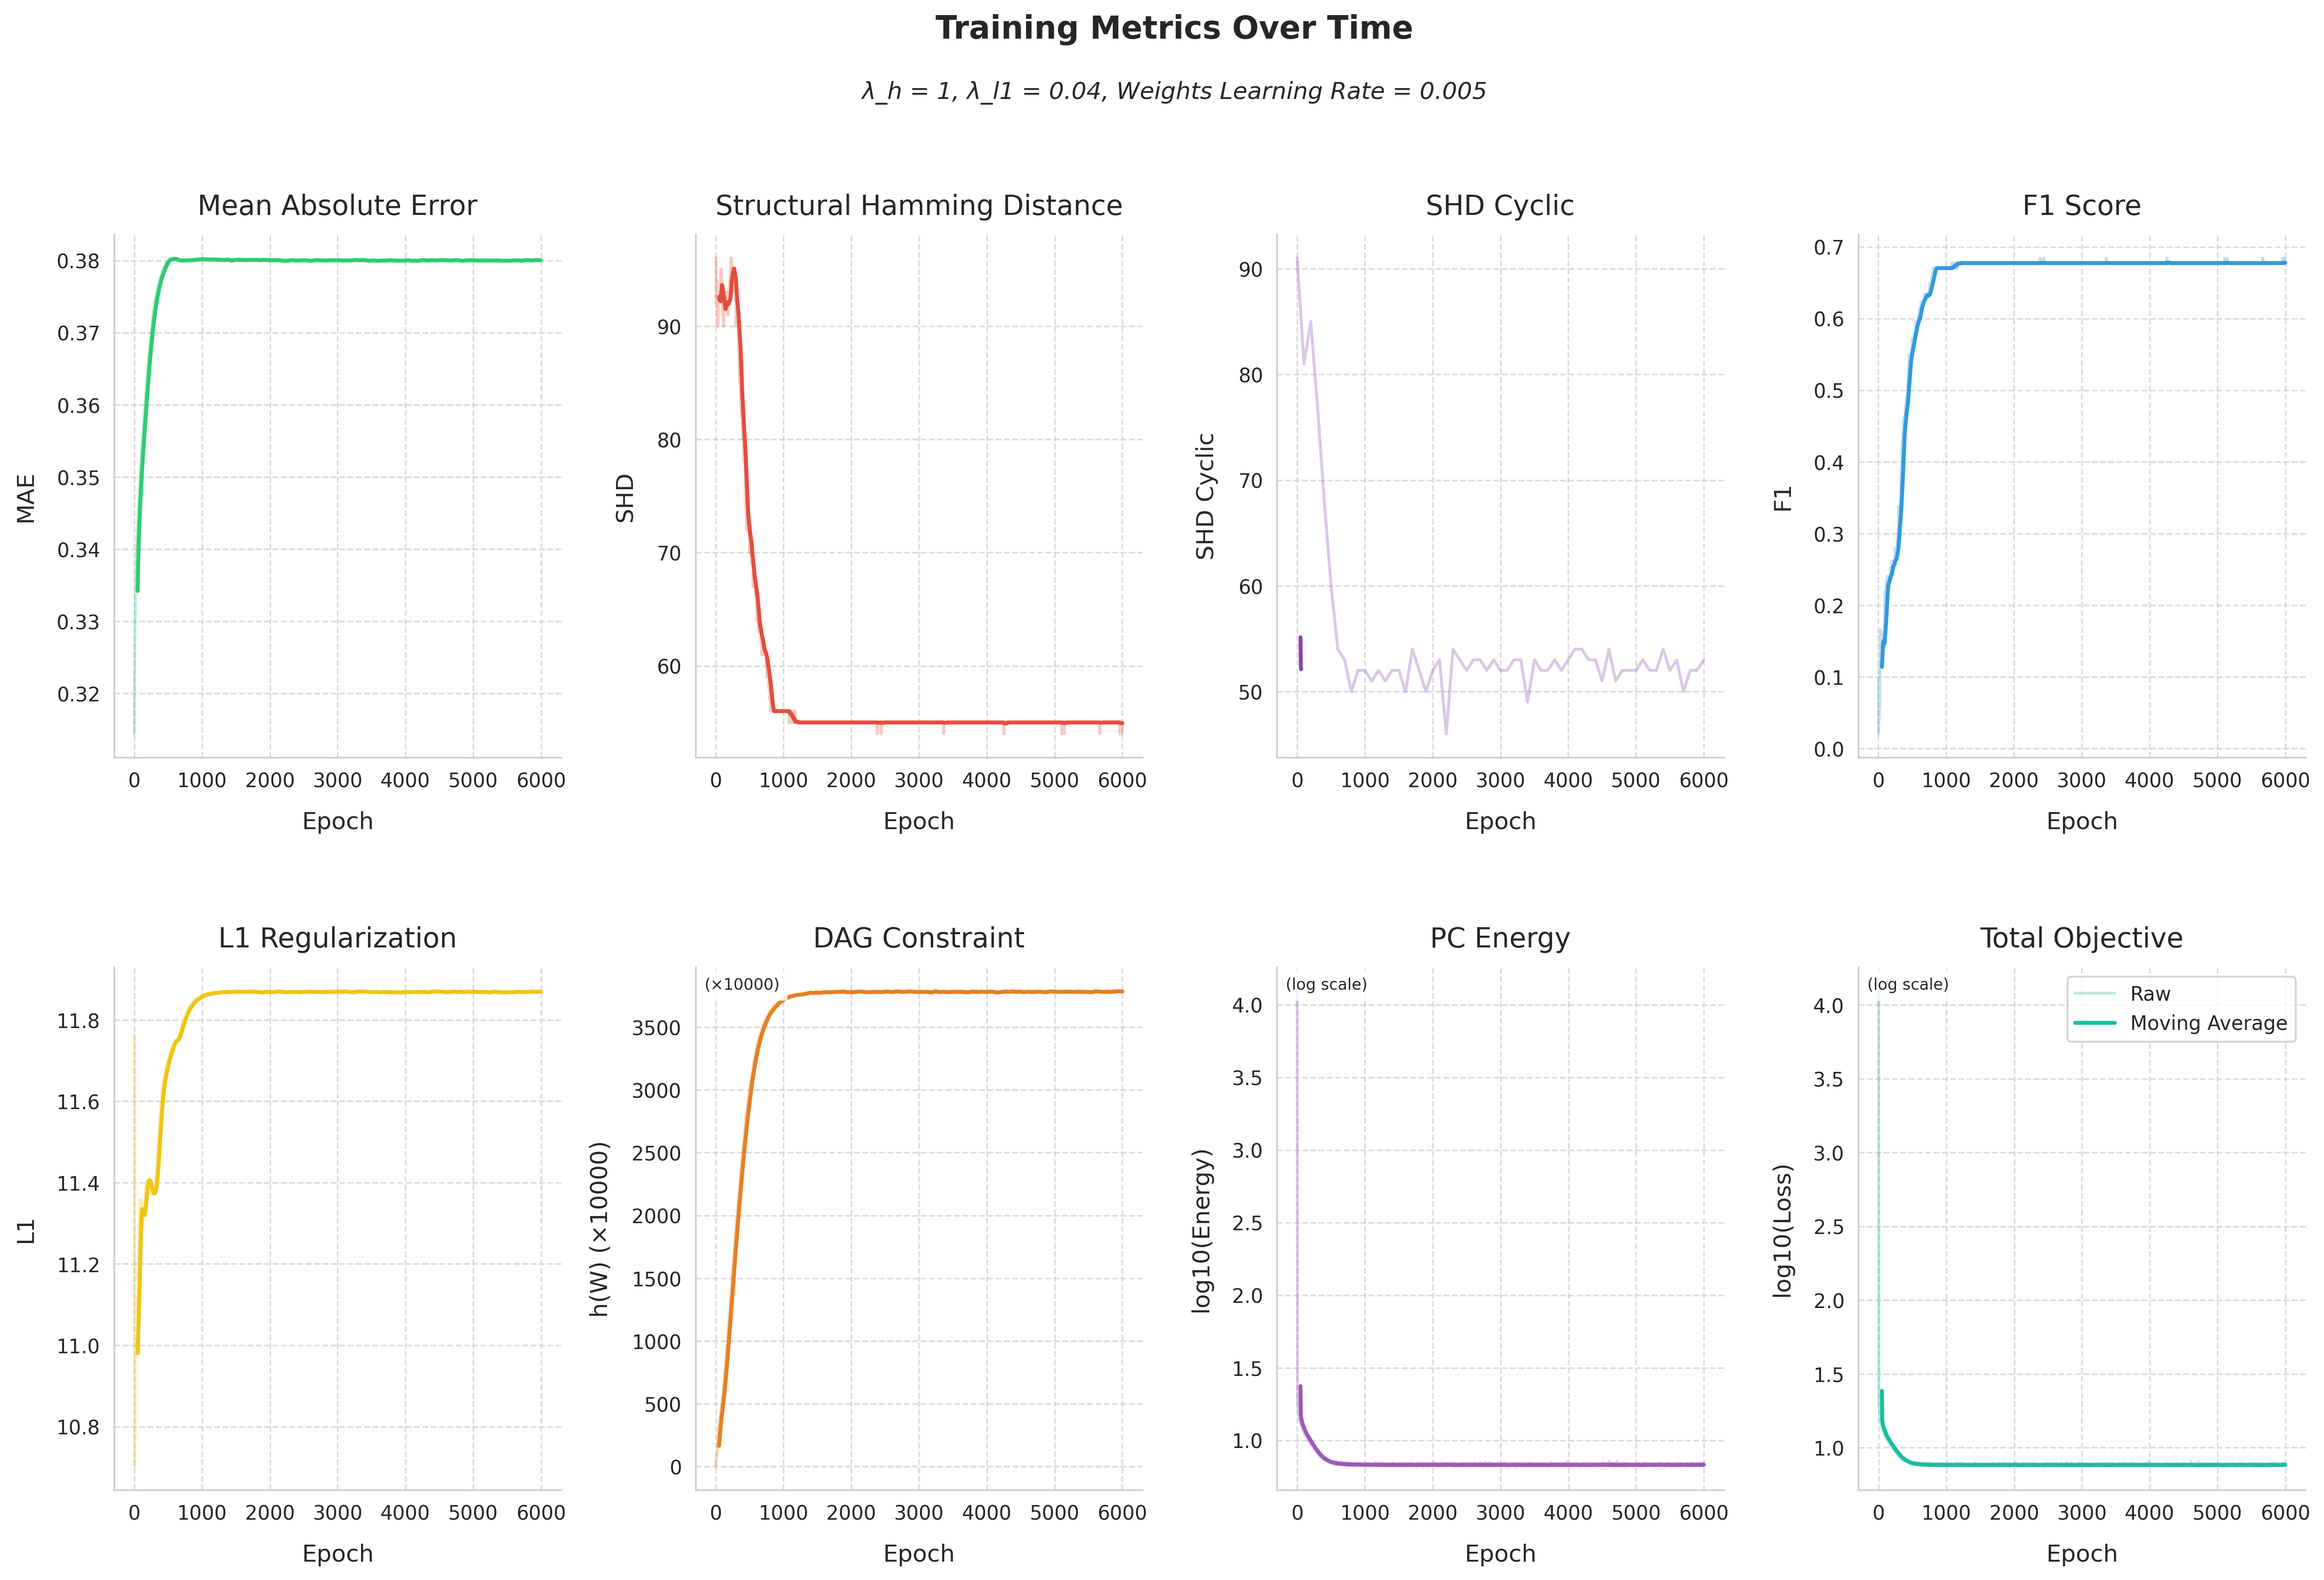

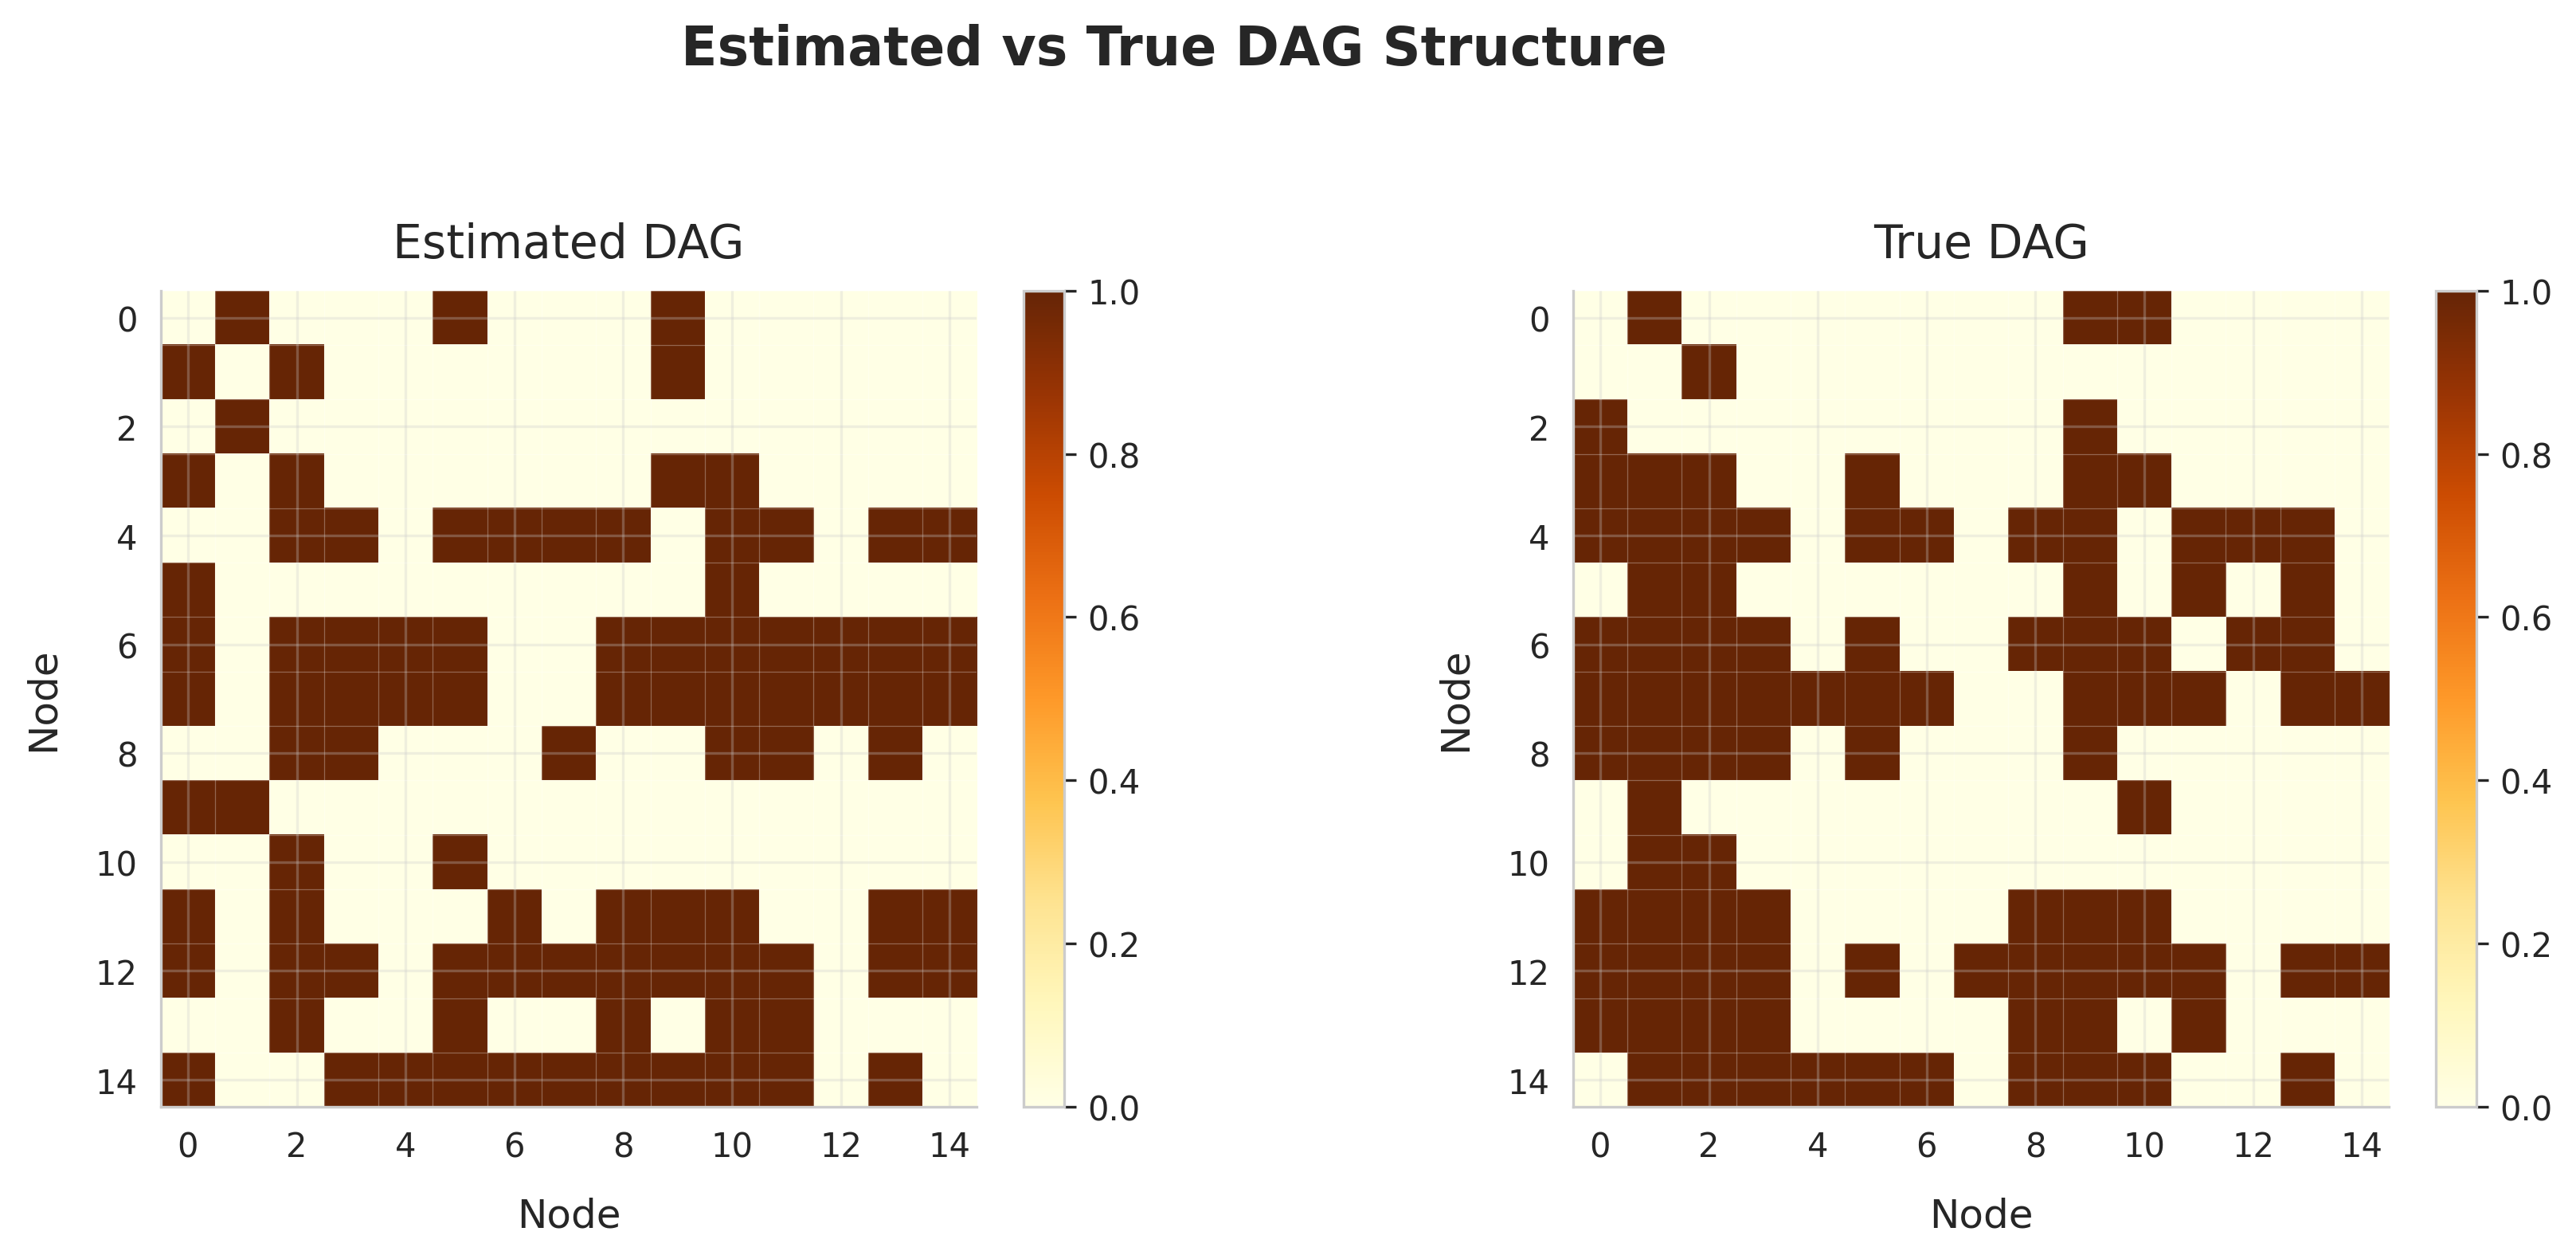

Is the estimated binary adjacency matrix a DAG? False
The h_reg term for the true weighted adjacency matrix W_true is: 1.0810
The h_reg term for the estimated weighted adjacency matrix W_est is: 1.4641
The first 5 rows and columns of the estimated weighted adjacency matrix W_est
[[ 0.      0.5524  0.0279 -0.2422  0.0422]
 [ 0.3616  0.      0.3603  0.0607  0.0341]
 [ 0.0341  0.3048  0.     -0.0791 -0.0372]
 [-0.5466  0.0911 -0.3322  0.     -0.0629]
 [-0.2858 -0.1602 -0.4597 -0.3639  0.    ]]


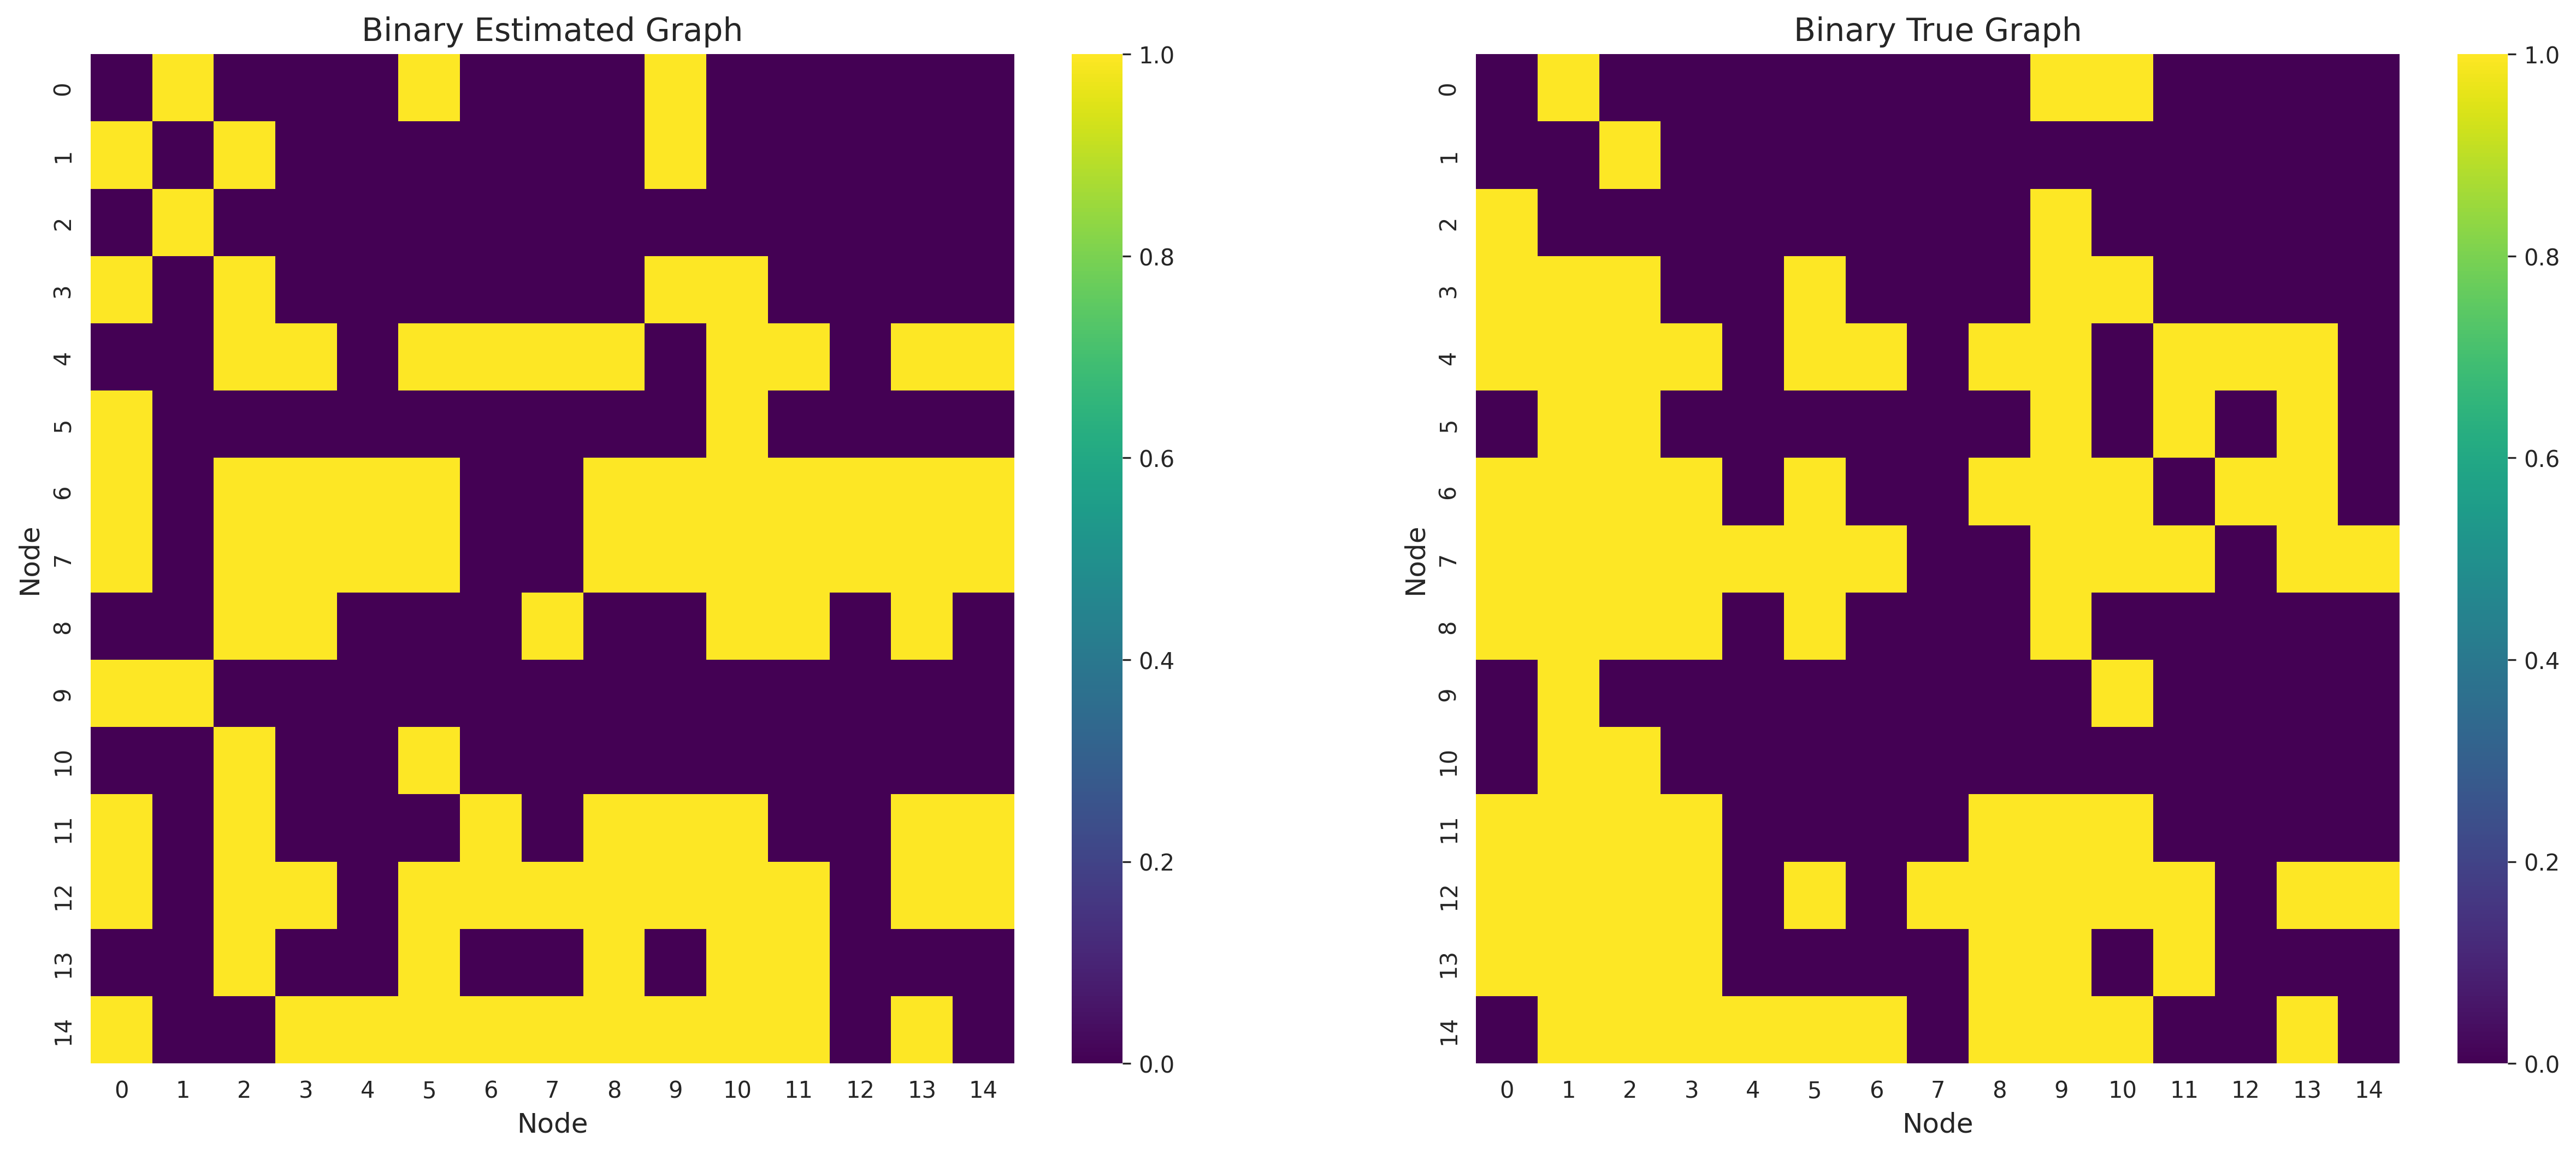

The number of edges in the true graph: 96.0
The number of edges in the estimated graph: 93


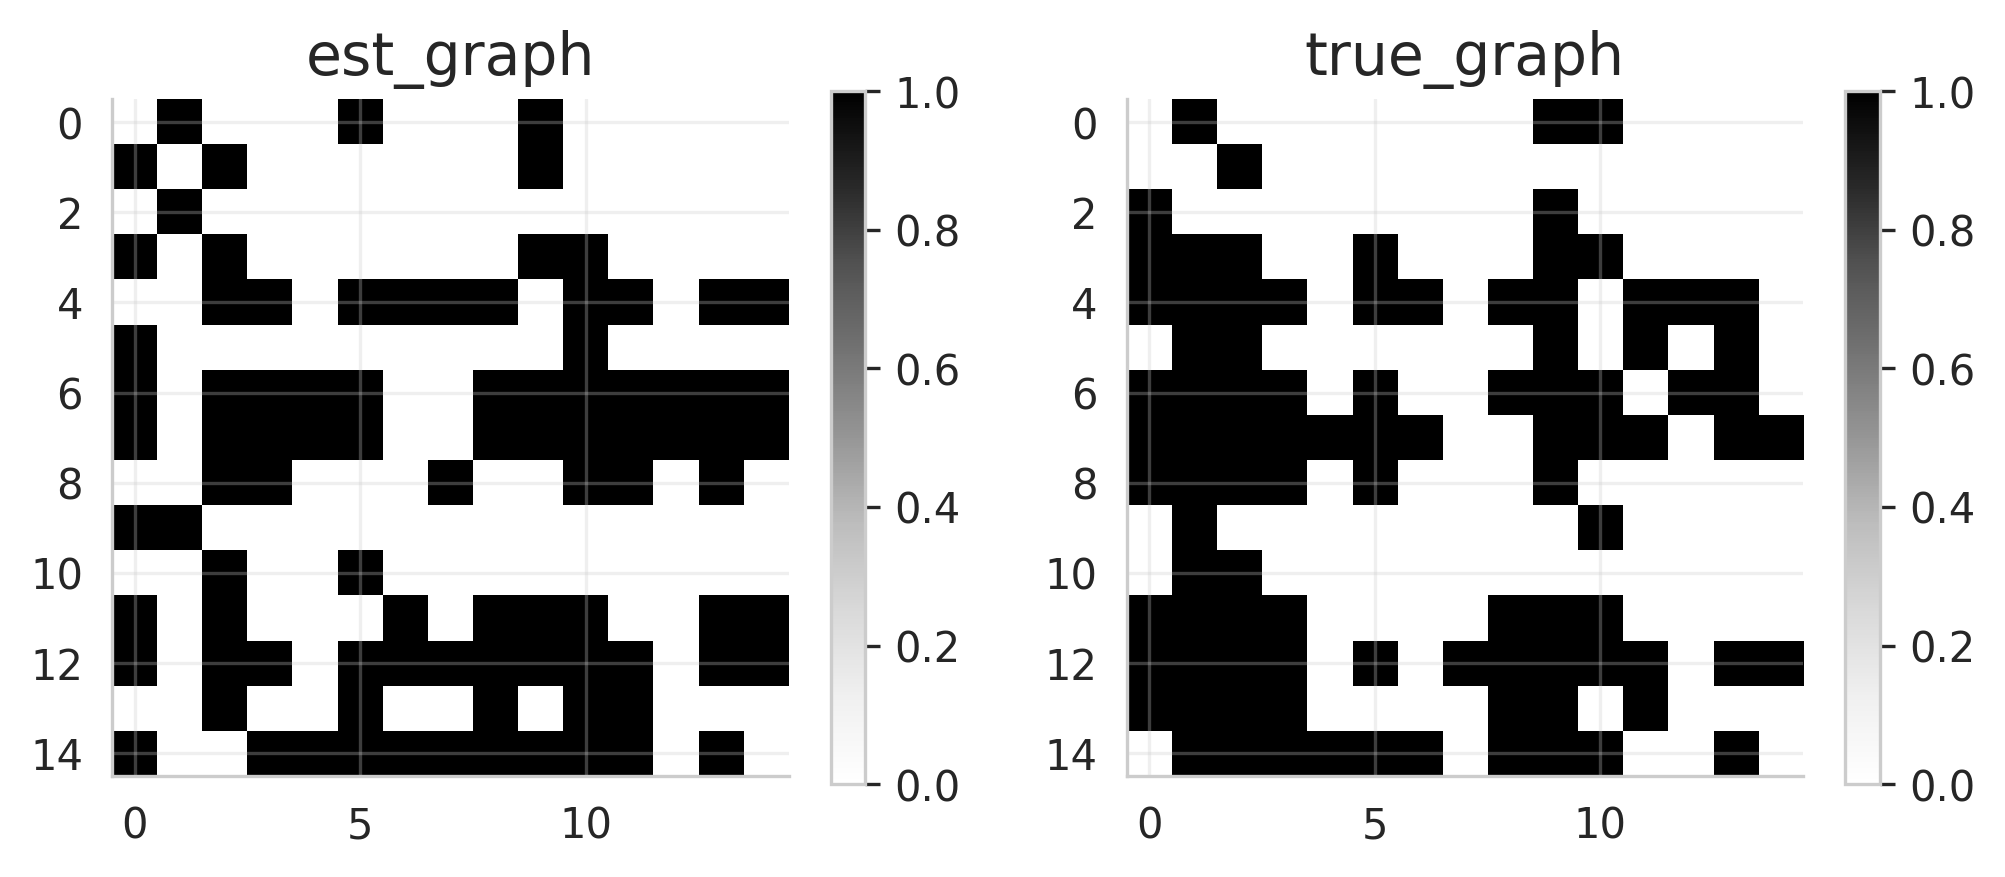

{'fdr': 0.2432, 'tpr': 0.5833, 'fpr': 2.0, 'shd': 49, 'nnz': 74, 'precision': 0.7568, 'recall': 0.5833, 'F1': 0.6588, 'gscore': 0.3958}


In [10]:
# Define experiment name
exp_name = f"bs_{batch_size}_lrw_{w_learning_rate}_lrh_{h_learning_rate}_lamh_{lam_h}_laml1_{lam_l1}_epochs_{nm_epochs}"

# Create subdirectory in linear folder with the name stored in exp_name
save_path = os.path.join('plots/linear_cyclic', exp_name)
os.makedirs(save_path, exist_ok=True)

# Reset to default style and set seaborn style
plt.style.use('default')
sns.set_style("whitegrid")

# Update matplotlib parameters
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Create a figure and subplots using GridSpec
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

# Adjust layout to make more room for title and subtitle
plt.subplots_adjust(top=0.85, hspace=0.4, wspace=0.3)

# Create axes
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax03 = fig.add_subplot(gs[0, 3])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
ax12 = fig.add_subplot(gs[1, 2])
ax13 = fig.add_subplot(gs[1, 3])  # New subplot for SHDs_cyclic

axes = [ax00, ax01, ax02, ax03, ax10, ax11, ax12, ax13]

# Plot configurations
plot_configs = [
    {'metric': MAEs, 'title': 'Mean Absolute Error', 'ylabel': 'MAE', 'color': '#2ecc71', 'ax': ax00},
    {'metric': SHDs, 'title': 'Structural Hamming Distance', 'ylabel': 'SHD', 'color': '#e74c3c', 'ax': ax01},
    {'metric': SHDs_cyclic, 'title': 'SHD Cyclic', 'ylabel': 'SHD Cyclic', 'color': '#8e44ad', 'ax': ax02},    
    {'metric': F1s, 'title': 'F1 Score', 'ylabel': 'F1', 'color': '#3498db', 'ax': ax03},      
    {'metric': l1_regs, 'title': 'L1 Regularization', 'ylabel': 'L1', 'color': '#f1c40f', 'ax': ax10},
    {'metric': h_regs, 'title': 'DAG Constraint', 'ylabel': 'h(W)', 'color': '#e67e22', 'ax': ax11},    
    {'metric': pc_energies, 'title': 'PC Energy', 'ylabel': 'Energy', 'color': '#9b59b6', 'ax': ax12},
    {'metric': objs, 'title': 'Total Objective', 'ylabel': 'Loss', 'color': '#1abc9c', 'ax': ax13}
]

# Create all subplots
for config in plot_configs:
    ax = config['ax']
    
    # Plot data with rolling average
    if config['title'] == 'SHD Cyclic':
        epochs = range(0, len(config['metric']) * every_n_epochs, every_n_epochs)
    else:
        epochs = range(len(config['metric']))
    
    # Determine if we should use log scale and/or scaling factor
    use_log_scale = config['title'] in ['PC Energy', 'Total Objective']
    scale_factor = 1e4 if config['title'] == 'DAG Constraint' else 1
    
    # Apply scaling and/or log transform to the metric
    metric_values = np.array(config['metric'])
    if use_log_scale:
        # Add small constant to avoid log(0)
        metric_values = np.log10(np.abs(metric_values) + 1e-10)
    metric_values = metric_values * scale_factor
    
    # Plot raw data
    raw_line = ax.plot(epochs, metric_values, 
                      alpha=0.3, 
                      color=config['color'], 
                      label='Raw')
    
    # Calculate and plot rolling average
    window_size = 50
    if len(metric_values) > window_size:
        rolling_mean = np.convolve(metric_values, 
                                 np.ones(window_size)/window_size, 
                                 mode='valid')
        ax.plot(range(window_size-1, len(metric_values)), 
                rolling_mean, 
                color=config['color'], 
                linewidth=2, 
                label='Moving Average')
    
    # Customize each subplot
    ax.set_title(config['title'], pad=10)
    ax.set_xlabel('Epoch', labelpad=10)
    
    # Adjust ylabel based on transformations
    ylabel = config['ylabel']
    if use_log_scale:
        ylabel = f'log10({ylabel})'
    if scale_factor != 1:
        ylabel = f'{ylabel} (×{int(scale_factor)})'
    ax.set_ylabel(ylabel, labelpad=10)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend if it's the total objective plot
    if config['title'] == 'Total Objective':
        ax.legend(loc='upper right')
        
    # Add note about scaling if applicable
    if use_log_scale or scale_factor != 1:
        transform_text = []
        if use_log_scale:
            transform_text.append('log scale')
        if scale_factor != 1:
            transform_text.append(f'×{int(scale_factor)}')
        ax.text(0.02, 0.98, f"({', '.join(transform_text)})", 
                transform=ax.transAxes, 
                fontsize=8, 
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Add overall title and subtitle with adjusted positions
fig.suptitle('Training Metrics Over Time', 
            fontsize=16, 
            weight='bold', 
            y=0.98)

subtitle = f'λ_h = {lam_h}, λ_l1 = {lam_l1}, Weights Learning Rate = {w_learning_rate}'
fig.text(0.5, 0.93, 
         subtitle, 
         horizontalalignment='center',
         fontsize=12,
         style='italic')

# Save and show the figure as a .pdf file at the specified location
plt.savefig(os.path.join(save_path, 'training_metrics.pdf'), 
            bbox_inches='tight', 
            dpi=300)
plt.show()

# Create a separate figure for the adjacency matrices comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Use a better colormap - options:
# 'YlOrBr' - Yellow-Orange-Brown (good for sparse matrices)
# 'viridis' - Perceptually uniform, colorblind-friendly
# 'Greys' - Black and white, professional
# 'YlGnBu' - Yellow-Green-Blue, professional
cmap = 'YlOrBr'  # Choose one of the above

# Plot estimated adjacency matrix (now on the left)
im1 = ax1.imshow(compute_binary_adjacency(W), cmap=cmap, interpolation='nearest')
ax1.set_title('Estimated DAG', pad=10)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlabel('Node', labelpad=10)
ax1.set_ylabel('Node', labelpad=10)

# Plot true adjacency matrix (now on the right)
im2 = ax2.imshow(B_true, cmap=cmap, interpolation='nearest')
ax2.set_title('True DAG', pad=10)
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_xlabel('Node', labelpad=10)
ax2.set_ylabel('Node', labelpad=10)

# Add overall title
fig.suptitle('Estimated vs True DAG Structure', 
             fontsize=16, 
             weight='bold', 
             y=1.05)

# Add grid lines to better separate the nodes
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(-.5, B_true.shape[0], 1), minor=True)
    ax.set_yticks(np.arange(-.5, B_true.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

# Improve layout
plt.tight_layout()

# Save the comparison plot as a .pdf file at the specified location
plt.savefig(os.path.join(save_path, 'dag_comparison.pdf'), 
            bbox_inches='tight', 
            dpi=300,
            facecolor='white',
            edgecolor='none')
plt.show()

# %%
# Now use a threshold of 0.3 to binarize the weighted adjacency matrix W
W_est = np.array(model.get_W())
B_est = compute_binary_adjacency(W_est, threshold=0.3)

# %%
# Check if B_est is indeed a DAG
def is_dag(adjacency_matrix):
    """
    Check if a given adjacency matrix represents a Directed Acyclic Graph (DAG).
    
    Parameters:
        adjacency_matrix (numpy.ndarray): A square matrix representing the adjacency of a directed graph.
        
    Returns:
        bool: True if the graph is a DAG, False otherwise.
    """
    # Create a directed graph from the adjacency matrix
    graph = nx.DiGraph(adjacency_matrix)
    
    # Check if the graph is a DAG
    return nx.is_directed_acyclic_graph(graph)

# Check if the estimated binary adjacency matrix B_est is a DAG
is_dag_B_est = is_dag(B_est)
print(f"Is the estimated binary adjacency matrix a DAG? {is_dag_B_est}")

# Define fucntion to compute h_reg based W with h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - d, here * denotes the hadamard product
def compute_h_reg(W):
    """This function computes the h_reg term based on the matrix W."""
    h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - W.shape[0]
    return h_reg

# Compute the h_reg term for the true weighted adjacency matrix W_true
h_reg_true = compute_h_reg(W_true)
print(f"The h_reg term for the true weighted adjacency matrix W_true is: {h_reg_true:.4f}")

# Compute the h_reg term for the estimated weighted adjacency matrix W_est
h_reg_est = compute_h_reg(W_est)
print(f"The h_reg term for the estimated weighted adjacency matrix W_est is: {h_reg_est:.4f}")

# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print("The first 5 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:5, :5]))

# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(true_matrix=B_true, est_matrix=B_est, save_path=os.path.join(save_path, 'adjacency_matrices.png'))

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the true graph: {np.sum(B_true)}")
print(f"The number of edges in the estimated graph: {np.sum(B_est)}")

# %%
# plot est_dag and true_dag
GraphDAG(B_est, B_true, save_name=os.path.join(save_path, 'est_dag_true_dag.png'))
# calculate accuracy
met_pcx = MetricsDAG(B_est, B_true) # expects first arg to be the predicted labels and the second arg to be the true labels
print(met_pcx.metrics)

In [ ]:
# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("tab10")

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjusting layout to 1 row and 3 columns
fig.suptitle('Performance Metrics Over Epochs', fontsize=16, weight='bold')

# Plot the MAE
sns.lineplot(x=range(len(MAEs)), y=MAEs, ax=axs[0], color=palette[0])
axs[0].set_title("Mean Absolute Error (MAE)", fontsize=14)
axs[0].set_xlabel("Epoch", fontsize=12)
axs[0].set_ylabel("MAE", fontsize=12)
axs[0].grid(True)

# Plot the SHD
sns.lineplot(x=range(len(SHDs)), y=SHDs, ax=axs[1], color=palette[2])
axs[1].set_title("Structural Hamming Distance (SHD)", fontsize=14)
axs[1].set_xlabel("Epoch", fontsize=12)
axs[1].set_ylabel("SHD", fontsize=12)
axs[1].grid(True)

# Plot the Energy
sns.lineplot(x=range(len(pc_energies)), y=pc_energies, ax=axs[2], color=palette[3])
axs[2].set_title("Energy", fontsize=14)
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_ylabel("Energy", fontsize=12)
axs[2].grid(True)

# Improve layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

In [ ]:
# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print("The first 4 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:11, :11]))

In [ ]:
# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(B_true, B_est)

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the estimated graph: {np.sum(B_est)}")
print(f"The number of edges in the true graph: {np.sum(B_true)}")

In [ ]:
# plot est_dag and true_dag
GraphDAG(B_est, B_true)
# calculate accuracy
met_pcax = MetricsDAG(B_est, B_true)
print(met_pcax.metrics)

# print experiment name
print(exp_name)

In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import GOLEM

# GOLEM learn
#gol = GOLEM(num_iter=2e4, lambda_2=1e4/X.shape[1], lambda_1=1e-2)
#gol = GOLEM(num_iter=2e4, lambda_2=0.0)  setting h_reg to 0 still allows model to be fit (no error thrown)
gol = GOLEM(num_iter=2e4, non_equal_variances=True, lambda_1=1e-2) # F1 of 60%
#g = GOLEM(num_iter=2e4, non_equal_variances=False) # F1 of 68%, default non_equal_variances=True
gol.learn(X)

# plot est_dag and true_dag
GraphDAG(gol.causal_matrix, B_true)

# calculate accuracy
gol_met = MetricsDAG(gol.causal_matrix, B_true)
print(gol_met.metrics)
print("The number of edges in golem graph: ", np.sum(gol.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import Notears

# notears learn
nt = Notears(lambda1=1e-3, h_tol=1e-5, max_iter=100) # default loss_type is 'l2', F1 of 27%
#nt = Notears(lambda1=1e-2, h_tol=1e-5, max_iter=10000, loss_type='logistic')
#nt = Notears(lambda1=1e-2, h_tol=1e-5, max_iter=10000, loss_type='poisson')
nt.learn(X)

# plot est_dag and true_dag
GraphDAG(nt.causal_matrix, B_true)

# calculate accuracy
nt_met = MetricsDAG(nt.causal_matrix, B_true)
print(nt_met.metrics)
print("The number of edges in notears graph: ", np.sum(nt.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import PC

# A variant of PC-algorithm, one of [`original`, `stable`, `parallel`]
pc = PC(variant='parallel', alpha=0.05, ci_test='fisherz') # F1 of 15%
#pc = PC(variant='stable', alpha=0.05) # F1 of 17%
#pc = PC(variant='original', alpha=0.05) # F1 of 19%
pc.learn(X)

# plot est_dag and true_dag
GraphDAG(pc.causal_matrix, B_true)

# calculate accuracy
pc_met = MetricsDAG(pc.causal_matrix, B_true)
print(pc_met.metrics)
print("The number of edges in pc graph: ", np.sum(pc.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms.ges.ges import GES

# GES learn
# method is one of ['r2', 'scatter']
ges = GES() # F1 of 42%
#ges = GES(criterion='bic', method='scatter') # F1 of 47%
#ges = GES(criterion='bic', method='r2') # F1 of 4%

# learn the graph structure
# create X_ges that adds noise to X because GES complains about singular matrix
X_ges = X + np.random.normal(0, 1, X.shape)**4
ges.learn(X)

# plot est_dag and true_dag
GraphDAG(ges.causal_matrix, B_true)

# calculate accuracy
ges_met = MetricsDAG(ges.causal_matrix, B_true)
print(ges_met.metrics)
print("The number of edges in ges graph: ", np.sum(ges.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import DirectLiNGAM

# measure : {'pwling', 'kernel'}, default='pwling'
g_ling = DirectLiNGAM(measure='pwling') # F1 of 74%
#g = DirectLiNGAM(measure='kernel') # F1 of nan - takes too long to run (even after 15 minutes not done)
g_ling.learn(X)

# plot est_dag and true_dag
GraphDAG(g_ling.causal_matrix, B_true)

# calculate accuracy
g_ling_met = MetricsDAG(g_ling.causal_matrix, B_true)
print(g_ling_met.metrics)
print("The number of edges in directlingam graph: ", np.sum(g_ling.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
from castle.algorithms import ICALiNGAM

# ICALiNGAM learn
# max_iter : int, optional (default=1000)
#g = ICALiNGAM(max_iter=1000) # F1 of 48%
g_ica = ICALiNGAM(max_iter=100000) # F1 of 51%
g_ica.learn(X)

# plot est_dag and true_dag
GraphDAG(g_ica.causal_matrix, B_true)

# calculate accuracy
g_ica_met = MetricsDAG(g_ica.causal_matrix, B_true)
print(g_ica_met.metrics)
print("The number of edges in ica graph: ", np.sum(g_ica.causal_matrix))
print("The number of edges in true graph: ", np.sum(B_true))

In [ ]:
#shd_dg = min_colperm_shd(equiv_class, learned_support) # dglearn
shd_our = shd_cyclic(B_true_EC, B_est) # our method
shd_gol = shd_cyclic(B_true_EC, gol.causal_matrix) # golem
shd_nt = shd_cyclic(B_true_EC, nt.causal_matrix) # notears
shd_icag = shd_cyclic(B_true_EC, g_ica.causal_matrix) # icalingam
shd_ling = shd_cyclic(B_true_EC, g_ling.causal_matrix) # lingam
#print("SHD to nearest member of equivalence class using dglearn: %d" % shd_dg)
print("SHD to nearest member of equivalence class using our method: %d" % shd_our)
print("SHD to nearest member of equivalence class using golem: %d" % shd_gol)
print("SHD to nearest member of equivalence class using notears: %d" % shd_nt)
print("SHD to nearest member of equivalence class using icalingam: %d" % shd_icag)
print("SHD to nearest member of equivalence class using lingam: %d" % shd_ling)

In [ ]:
from dglearn import *

# learn structure using tabu search, plot learned structure
tabu_length = X.shape[1] # number of variables
patience = 4

manager = CyclicManager(X, bic_coef=0.5)
learned_support, best_score, log = tabu_search(manager, tabu_length, patience, first_ascent=False, verbose=1) # returns a binary matrix as learned support
# the above does not finish running (within 2 hours) for a graph with 15 nodes and 4000 samples # need to run overnight

In [ ]:
# perform virtual edge correction
print("virtual edge correction...")
learned_support = virtual_refine(manager, learned_support, patience=0, max_path_len=6, verbose=1)

# remove any reducible edges
learned_support = reduce_support(learned_support, fill_diagonal=False)

In [ ]:
# plot est_dag and true_dag
GraphDAG(learned_support, B_true)

# calculate accuracy
dg_met = MetricsDAG(learned_support, B_true)
print(dg_met.metrics)

In [ ]:
# get edge list from B_true using networkx
G_true = nx.DiGraph(B_true)
edges_true = list(G_true.edges())
# compute performance metric: SHD
true_graph = AdjacencyStucture(X.shape[1], edges_true)
search = GraphEquivalenceSearch(true_graph)
search.search_dfs()
equiv_class = [binary2array(bstr) for bstr in search.visited_graphs]
#shd_dg = min_colperm_shd(equiv_class, learned_support) # dglearn
shd_our = min_colperm_shd(equiv_class, B_est) # our method
shd_gol = min_colperm_shd(equiv_class, gol.causal_matrix) # golem
shd_nt = min_colperm_shd(equiv_class, nt.causal_matrix) # notears
shd_icag = min_colperm_shd(equiv_class, g_ica.causal_matrix) # icalingam
shd_ling = min_colperm_shd(equiv_class, g_ling.causal_matrix) # lingam
#print("SHD to nearest member of equivalence class using dglearn: %d" % shd_dg)
print("SHD to nearest member of equivalence class using our method: %d" % shd_our)
print("SHD to nearest member of equivalence class using golem: %d" % shd_gol)
print("SHD to nearest member of equivalence class using notears: %d" % shd_nt)
print("SHD to nearest member of equivalence class using icalingam: %d" % shd_icag)
print("SHD to nearest member of equivalence class using lingam: %d" % shd_ling)

In [ ]:
print("Number of graphs in the equivalence class: %d" % len(equiv_class))